In [3]:
%matplotlib inline
import numpy as np
import math
from common.image_preprocessing import data_all, data_temp, temp_from_original
from common.show_thumbnails import show_inline_notebook
from pathlib import Path, PurePath
import time
import os

sz = 128
temp_relative_path = PurePath(f"{sz}x{sz}") / 'clahe_processed'
eevorg_temp = data_temp / 'eevorg' / temp_relative_path
processed_imgs = {}
rejected = []

# def calc_entropy(img):
#    bins, _ = np.histogram(img)
#    bins = bins / sum(bins)
#    return sum([-b * math.log(b+1e-6) for b in bins])
    
start_time = time.time()
npy_filepaths = list(eevorg_temp.glob('*.npy'))
for npy_filepath in npy_filepaths:
    img = np.load(npy_filepath)
    # entropy = calc_entropy(img)
    # if entropy < 0.1:
    #    print(npy_filepath, entropy, end='\r')
    #    Path(npy_filepath)
    #    os.rename(npy_filepath, )
    #    rejected.append(img)
    #    if len(rejected) > 20:
    #        show_inline_notebook(rejected[:10], rejected[10:20])
    #        rejected = []
    #    continue
    img = np.reshape(img, (img.shape[0],img.shape[1],1))
    processed_imgs[npy_filepath.stem] = img
    if len(processed_imgs) % 100 == 0:
        print(npy_filepath.stem, img.shape, end='\r')
end_time = time.time()

print(f"Loaded {len(processed_imgs)} npy in {end_time - start_time} seconds")

image_processing: DATA_ALL=G:\DataAll; DATA_TEMP=E:\Data\zebtrastack_temp
5113121301 (128, 128, 1)51240313000 (128, 128, 1)52141224011 (128, 128, 1)62140111011 (128, 128, 1)Loaded 50307 npy in 819.4021189212799 seconds


In [2]:
test_count = int(len(processed_imgs)/10)
processed_img_list = list(processed_imgs.values())
import random
random.shuffle(processed_img_list)
x_test = processed_img_list[:test_count]
x_train = processed_img_list[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(f"Training data has shape {x_train.shape}")
print(f"Testing data has shape {x_test.shape}")

Training data has shape (45277, 128, 128, 1)
Testing data has shape (5030, 128, 128, 1)


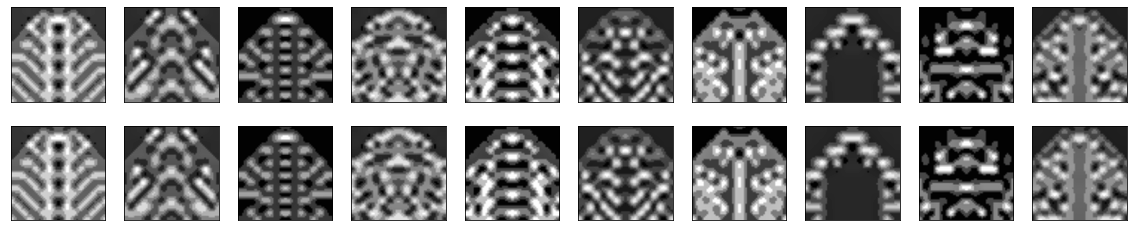

In [3]:
from cxr_projection.show_original_decoded import show_grayscale, show_original_decoded
import random
show_range = np.array([random.choice(x_test) for n in range(10)])
show_original_decoded(show_range, show_range, sz)

In [2]:
from cxr_projection.zebrastack_v0_model import create_encoder, create_decoder, create_autoencoder
retina, encoder, shape, [z_mean, z_log_var, z] = create_encoder()
decoder = create_decoder(shape)
autoencoder = create_autoencoder(retina, encoder, [z_mean, z_log_var, z], decoder)

Model: "v1_to_pulvinar_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
retina_128 (InputLayer)         (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
v1_conv2d (Conv2D)              (None, 128, 128, 32) 832         retina_128[0][0]                 
__________________________________________________________________________________________________
v1_maxpool (MaxPooling2D)       (None, 64, 64, 32)   0           v1_conv2d[0][0]                  
__________________________________________________________________________________________________
v1_dropout (SpatialDropout2D)   (None, 64, 64, 32)   0           v1_maxpool[0][0]                 
_____________________________________________________________________________

In [1]:
from cxr_projection.zebrastack_v0_model import vae_loss
optimizer = 'adam'
autoencoder.compile(optimizer=optimizer, 
                    loss=lambda y_true, y_pred: vae_loss(z_mean, z_log_var, y_true, y_pred))

autoencoder.fit(x_train, x_train, 
                epochs=128, batch_size=128,
                shuffle=True, validation_data=(x_test, x_test))

Using TensorFlow backend.


NameError: name 'autoencoder' is not defined

In [6]:
from functools import lru_cache
import numpy as np

# @lru_cache(maxsize=None)
def decode_latent(decoder, latent_vector:tuple):
    """
    helper to decode latent, with caching to speed up
    # Arguments
        decode_only: model for decoding
        latent_vector: _tuple_ representing the vector to be decoded
    # Returns
        decoded image
    """
    latent_vector_arr = np.array([latent_vector])
    return decoder.predict(latent_vector_arr) 

<IPython.core.display.Javascript object>


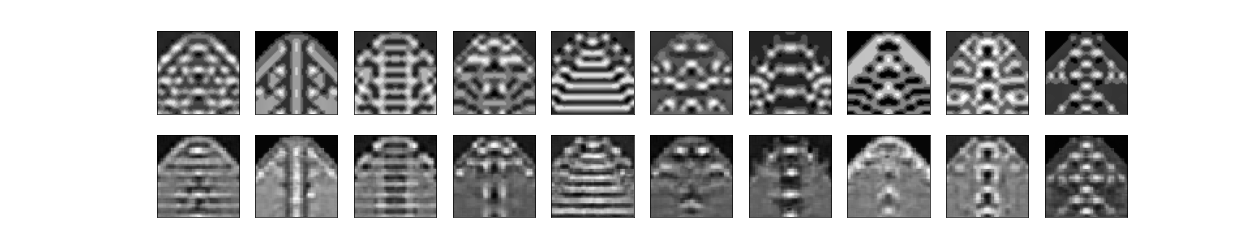

In [13]:
from cxr_projection.show_original_decoded import show_grayscale, show_original_decoded
import random

show_range = np.array([random.choice(x_test) for n in range(10)])
encode_only_imgs = encoder.predict(show_range)
decoded_imgs = \
    [decode_latent(decoder, tuple(latent_vector)) 
         for latent_vector in encode_only_imgs[2]]
show_original_decoded(show_range, decoded_imgs, sz)

In [15]:
def update_image_for_sliders(**kwargs):
    from scipy.ndimage import zoom
    # print(tuple(kwargs.values()))
    decoded_pixel_array = decode_latent(decoder, tuple(kwargs.values()))
    interp_array = decoded_pixel_array.reshape(sz,sz)
    print(interp_array[0])
    # interp_array = zoom(decoded_pixel_array.reshape(sz,sz), 4.0, order=0)
    # interp_array = interp_array.reshape(sz*4, sz*4)
    # ax.imshow(interp_array, cmap='gray')
    # a=im.get_array()    
    im.set_array(interp_array * 1.0)
    fig.canvas.draw()
    return kwargs['1']

In [16]:
%matplotlib notebook
from ipywidgets import FloatSlider, interactive_output, Layout, HBox, VBox

kwargs = {}

for k in range(12):
    kwargs[str(k)] = \
        FloatSlider(value = 0,
                    min = -3.0, max = 3.0, 
                    step = 0.01,
                    orientation='vertical',
                    layout=Layout(padding='0%'))

decoded_pixel_array = decode_latent(decoder, tuple([slider.value for slider in kwargs.values()]))
interp_array = decoded_pixel_array.reshape(sz,sz)

<IPython.core.display.Javascript object>


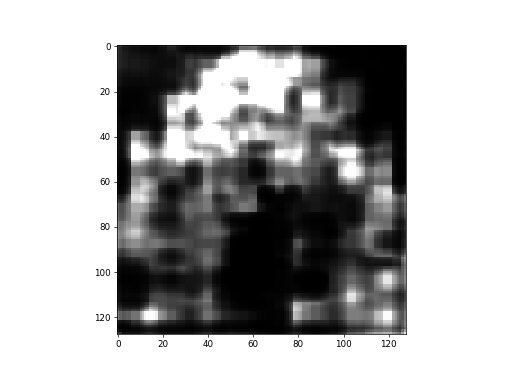

Output(layout=Layout(height='350px'))

In [17]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
im = ax.imshow(interp_array, cmap='gray')

slider_widgets = interactive_output(update_image_for_sliders, kwargs)
slider_widgets.layout.height = '350px'

import gc
gc.disable()
display(HBox(list(kwargs.values()), layout = Layout(padding='0%')))
display(slider_widgets)

In [ ]:
autoencoder.save_weights('eevorg_autoencoder_weights_32_64_64_millionth_kldiv.h5')

## TODO
- Filter uniform eevorg using minimum entropy

- Try RE instead of MSE
- Find closest eevorg for a given one
- Show SD on slider
- Find closest eevorg for latent coordinate (slider settings)
- Mutate eevorg based on latent coordinate
- 8D latent space


In [ ]:
gc.enable()

In [ ]:
%matplotlib notebook
test_imgs = np.array([random.choice(x_test) for n in range(10)])
latent_vectors = encoder.predict(test_imgs)[2]
decoded_imgs = []
residual_imgs = []
for test_img, latent_vector in zip(test_imgs, latent_vectors):
    decoded_imgs.append(decode_latent(decoder, tuple(latent_vector)))
    residual_imgs.append(test_img - decoded_img)
    
show_original_decoded(test_imgs, decoded_imgs, sz)

In [ ]:
%matplotlib notebook
test_img = [random.choice(x_test)]
latent_vector = encoder.predict([test_img])[2][0]
decoded_img = decode_latent(decoder, tuple(latent_vector))
residual_img = test_img - decoded_img

fig, axs = plt.subplots(3,2, figsize =(10,10), sharex='col')
axs[0][0].imshow(np.reshape(test_img, (sz,sz)), cmap='gray')
axs[0][1].hist(np.ndarray.flatten(test_img[0]),density=1, bins=10) 
axs[1][0].imshow(np.reshape(decoded_img, (sz,sz)), cmap='gray')
axs[1][1].hist(np.ndarray.flatten(decoded_img),density=1, bins=10) 
axs[2][0].imshow(np.reshape(residual_img, (sz,sz)), cmap='gray')
axs[2][1].hist(np.ndarray.flatten(residual_img),density=1, bins=10)


In [ ]:
test_img[0].shape

In [ ]:
from PIL import Image
import cv2
import numpy as np

test_img = [random.choice(x_test)]
latent_vector = encoder.predict([test_img])[2][0]
decoded_img = decode_latent(decoder, tuple(latent_vector))
residual_img = test_img - decoded_img
residual_img = np.reshape(residual_img, (sz,sz))
print(residual_img.shape, np.histogram(residual_img))
cv2.imwrite("test.jpg", residual_img*256 + 128, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

reresidual_img = cv2.imread("test.jpg")
reresidual_img = cv2.cvtColor(reresidual_img, cv2.COLOR_RGB2GRAY)
print(reresidual_img.shape, np.histogram(reresidual_img))
retest_img = np.reshape(decoded_img, (sz,sz)) + reresidual_img
print(retest_img.shape)

fig, axs = plt.subplots(2,1, figsize =(10,10))
axs[0].imshow(np.reshape(test_img, (sz,sz)), cmap='gray')
axs[1].imshow(np.reshape(retest_img, (sz,sz)), cmap='gray')